Objetivos: demostrar o uso básico para ajustar um modelo SINDy, assim como fornecer uma visão geral simples das funcionalidades básica do PySINDy incluindo diferentes formas de dados de entrada, métodos de otimização, métodos de diferenciação e bibliotecas de recursos personalizados.

# Identificação esparsa de sistemas dinâmicos não-lineares (SINDy)

O método SINDy combina técnicas de sparsity-promoting e aprendizado de máquina com sistemas dinâmicos não-lineares para descobrir equações que regem o sistema a partir de dados de medição, foi introduzido por Brunton et al. (2016a). Para isto utilizamos a biblioteca PySINDy (https://github.com/dynamicslab/pysindy). 

Com o objetivo de melhor intendimento será apresentado um breve resumo da técnica. Suponha que temos um conjunto de medidas $x(t)\in \mathbb{R}^n$ de algum sistema físico em diferentes pontos no tempo $t$. SINDy procura representar a evolução temporal de $x(t)$ em termos de uma função não-linear $f$:

$$ \frac{d}{dt}x(t) = f(x(t)). $$

Esta equação constitui um sistema dinâmico para as medidas $x(t)$. O vetor $x(t) = [x_1(t), x_2(t), \dots x_n(t)]^\top$ fornece o estado do sistema físico no tempo $t$. A função $f(x(t))$ contém informações de como o sistema evolui no tempo. A ideia-chave por trás do SINDy é que a função $f$ geralmente é esparsa (matriz ou vetor que comtém elementos não-nulos) no espaço de um conjunto apropriado de funções básicas. Por exemplo, a função:
$$ 
    \frac{d}{dt}x = f(x)
    = \begin{bmatrix} f_1(x)\\f_2(x) \end{bmatrix}
    = \begin{bmatrix}1 - x_1 + 3x_1x_2 \\ x_2^2 - 5x_1^3 \end{bmatrix}
$$

é esparso em relação ao conjunto de polinômios de duas variáveis no sentido de que se escrevermos uma expansão das funções componentes de $f$ nesta base (por exemplo, $f_ {1} (x) = \sum_ {i = 0}^\infty\sum_{j = 0}^\infty a_{i, j}x_1^ix_2^j $), apenas um pequeno número de coeficientes ($a_{i, j}$) seria diferente de zero. Assim, o método emprega regressão esparsa para encontrar uma combinação linear de funções básicas que melhor capturam o comportamento dinâmico do sistema físico.

Para determinar a função $f$ dos dados, coleta-se uma série temporal do estado $x(t)$ e medir-se a derivada $\dot x(t)$ ou
aproxime-o numericamente de $x(t)$, ou seja, medidas diretamente ou aproximadas numericamente. Os dados são amostrados em vários tempos t1, t2, ⋯, tm e organizados em duas matrizes:

$$
    X = \begin{bmatrix}
        x_1(t_1) & x_2(t_1) & \dots & x_n(t_1) \\
        x_1(t_2) & x_2(t_2) & \dots & x_n(t_2) \\
        \vdots   & \vdots   &       & \vdots   \\ 
        x_1(t_m) & x_2(t_m) & \dots & x_n(t_m)
    \end{bmatrix},
    \qquad
    \dot{X} = \begin{bmatrix} 
        \dot{x_1}(t_1) & \dot{x_2}(t_1) & \dots & \dot{x_n}(t_1) \\
        \dot{x_1}(t_2) & \dot{x_2}(t_2) & \dots & \dot{x_n}(t_2) \\
        \vdots         & \vdots         &       & \vdots \\
        \dot{x_1}(t_m) & \dot{x_2}(t_m) & \dots & \dot{x_n}(t_m)
    \end{bmatrix}.
$$

O proximo passo é construir uma biblioteca $\Theta(X)$ consistindo de possiveis funções não-lineares das colunas de X, ou funções bases. Por exemplo, $\Theta(X)$ pode consistem em termos constantes, polinomiais e trigonométricos. $\Theta(X)$ é definido como,

$$
    \Theta(X) = \begin{bmatrix}
        \mid        & \mid        &       & \mid \\
        \theta_1(X) & \theta_2(X) & \dots & \theta_\ell(X) \\
        \mid        & \mid        &       & \mid 
    \end{bmatrix}.
$$

Por exemplo, se $\theta_1(x), \theta_2(x), \dots, \theta_\ell(x)$ são monômios ($\theta_i(x) = x^{i-1}$), então:

$$
    \theta_3(X) = \begin{bmatrix}
        \mid     & \mid         &       & \mid     & \mid         &      & \mid \\
        x_1(t)^2 & x_1(t)x_2(t) & \dots & x_2(t)^2 & x_2(t)x_3(t) &\dots & x_n^2(t) \\
        \mid     & \mid         &       & \mid     & \mid         &      & \mid
    \end{bmatrix},
$$

onde produtos e potencias vetoriais são entendidos como elementos. Cada coluna de $\Theta(X)$ representa uma função candidata para o lado direito da Eq. 1. Há uma enorme liberdade na escolha das entradas nesta matriz de não-linearidades. Porque acredita-se  que apenas algumas dessas não-linearidades estão ativas em cada linha de $f$, então pode-se configurar um problema de regressão esparsa para determinar os vetores esparsos de coeficientes:

$$
    \Xi = \begin{bmatrix}
        \mid  & \mid  &       & \mid \\
        \xi_1 & \xi_2 & \dots & \xi_n \\
        \mid  & \mid  &       & \mid
    \end{bmatrix}.
$$

O vetor $\xi_i$ fornece os coeficientes para uma combinação linear das funções de base $\theta_1(x), \theta_2(x), \dots, \theta_\ell (x)$ representando a $i$th função componente de $f$: $f_i(x)$. Ou seja, $f_i(x) = \Theta \left (x^\top\right)\xi_i$, onde $\Theta\left(x^\top\right)$ é entendido como um vetor linha que consiste de funções simbólicas (enquanto $\Theta(X)$ é uma matriz cujas entradas são valores numéricos). Com cada um dos objetos $X$, $\dot X$, $\Theta(X)$ e $\Xi$ sendo definidos,pode-se escrever o problema de aproximação subjacente a SINDy:

$$ \dot X \approx \Theta(X)\Xi. $$

Com base na ultima equação pode-se definir a estrutura básica do PySINDy, em que envolve um objeto de cada uma destas clases $X$, $\dot X$, $\Theta(X) e o uso delas, junto com uma matriz de dados fornecida pelo usuário, para encontrar um sistema dinâmico governante. Elas são:

* pysindy.differentiate: realiza diferenciação numérica para calcular $\dot X$ de $X$;
* pysindy.feature_library: permite ao usuário especificar um conjunto de funções de biblioteca e manipular a formação de $\Theta (X)$;
* pysindy.optimizers: fornece um conjunto de solucionadores de regressão esparsos para determinar $\Xi$.

# Exemplo 1 - posição de uma partícula
Suponha que temos medidas da posição de uma partícula obedecendo ao seguinte sistema dinâmico em diferentes pontos no tempo:

$$
    \frac{d}{dt} \begin{bmatrix} x \\ y \end{bmatrix}
    = \begin{bmatrix} -2x \\ y \end{bmatrix}
    = \begin{bmatrix} -2 & 0 \\ 0 & 1 \end{bmatrix}
    \begin{bmatrix} x \\ y \end{bmatrix}
$$

Observe que este sistema de equações diferenciais se desacopla em duas equações diferenciais cujas soluções são simplesmente $x (t) = x_0e^{- 2t}$ e $y (t) = y_0e^t$, onde $x_0 = x (0)$ e $y_0 = y (0)$ são as condições iniciais.

Usando as condições iniciais $x_0 = 3$ e $y_0 = 0.5$, construímos a matriz de dados $X$.

x' = -2.000 x
y' = 1.000 y


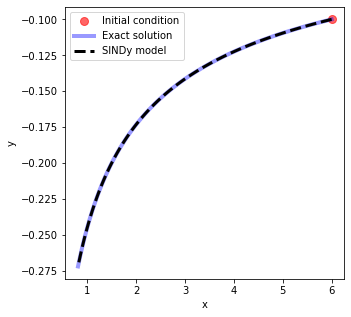

In [ ]:
# Importar as bibliotecas
import numpy as np
import pysindy as ps
import matplotlib.pyplot as plt

# Definir as condições iniciais e vetores
x0 = 3
y0 = 0.5
t = np.linspace(0, 1, 100)

# Difinir a equação diferencial
x = x0 * np.exp(-2 * t) # equação 1
y = y0 * np.exp(t)      # equação 2
X = np.stack((x, y), axis=-1)  # A primeira coluna é x, a segunda é y, Função para juntar a uma sequência de matrizes ao longo de um novo eixo.

# Definir um método de diferenciação do submódulo de diferenciação
differentiation_method = ps.FiniteDifference(order=2)

# Definir o submodulo "pysindy.feature_library"
poly_order = 3
feature_library = ps.PolynomialLibrary(degree=poly_order)

# Definir qual otimizador deve ser usado
threshold = 0.2
optimizer = ps.STLSQ(threshold=threshold)

# Finalmente, reunimos esses três componentes em um objeto SINDy
model = ps.SINDy(
    differentiation_method=differentiation_method,
    feature_library=feature_library,
    optimizer=optimizer,
    feature_names=["x", "y"]
)
# Seguindo o fluxo de trabalho do scikit-learn, primeiro instanciamos um objeto de classe SINDy com as propriedades desejadas e, em seguida, ajustamos aos dados em uma etapa separada.
model.fit(X, t=t);

# Imprimir as equações governantes descobertas pelo modelo
model.print()

# Uma vez que o modelo SINDy tenha sido ajustado, podemos usá-lo para desenvolver novas condições iniciais no tempo com a função simular
xi = 6
yi = -0.1
t_test = np.linspace(0, 1, 100)
x_test = xi * np.exp(-2 * t_test)
y_test = yi * np.exp(t_test)
sim = model.simulate([xi, yi], t=t_test)

# plotar o resultado
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.plot(xi, yi, "ro", label="Initial condition", alpha=0.6, markersize=8)
ax.plot(x_test, y_test, "b", label="Exact solution", alpha=0.4, linewidth=4)
ax.plot(sim[:, 0], sim[:, 1], "k--", label="SINDy model", linewidth=3)
ax.set(xlabel="x", ylabel="y")
ax.legend()

OBS: Observe que se a biblioteca que escolhemos fosse inadequada para o problema em questão (ou seja, se a dinâmica não pudesse ser bem aproximada como uma combinação linear esparsa de funções de biblioteca), então SINDy teria falhado em produzir um modelo razoável. Por exemplo, se resolvermos o mesmo problema, mas usando senos e cossenos como nossas funções de base, SINDy é incapaz de encontrar um modelo esparso para a dinâmica:

# Exemplo 2 - sistema de Lorenz
O sistema Lorenz serve como um exemplo de ODE não linear cujas soluções exibem dinâmica caótica evoluindo em um atrator estranho. O sistema Lorenz é dado por:

$$ 
   \begin{aligned} 
   \dot x & = \sigma(y-x)\\ 
   \dot y & = x(\rho - z) - y \\ 
   \dot z & = xy - \beta z, 
   \end{aligned} 
 $$


com $ \sigma = 10 $, $ \rho = 28 $ e $ \beta = \tfrac {8} {3} $ para este exemplo. Geramos nossos dados de treinamento a partir da condição inicial $(- 8, 8, 27)$. Observe que, para este exemplo, também coletamos medidas de derivadas de variáveis de estado, $ (\dot x, \dot y, \dot z) $.


x0' = -10.000 x0 + 10.000 x1
x1' = 28.000 x0 + -1.000 x1 + -1.000 x0 x2
x2' = -2.667 x2 + 1.000 x0 x1


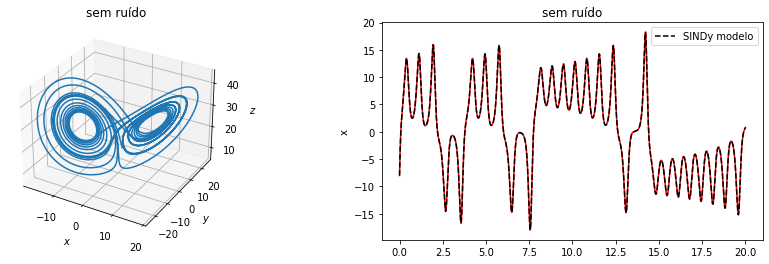

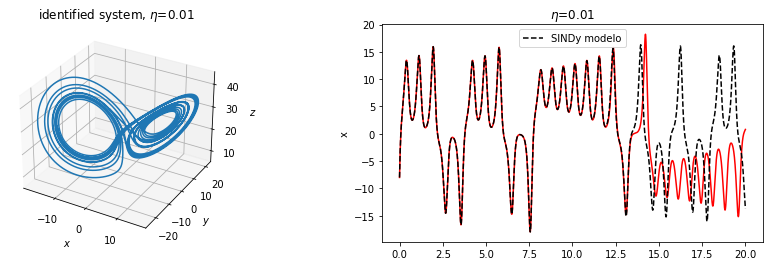

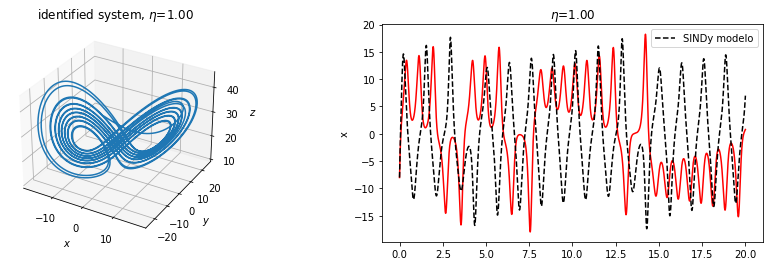

In [ ]:
# Importar as bibliotecas
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cm import rainbow
import numpy as np
from scipy.integrate import odeint
from scipy.io import loadmat
import pysindy as ps

# Definir as condições iniciais e vetores
omega = 10
rho = 28
beta = 8/3
dt = 0.001 # passo 
t_train = np.arange(0, 100, dt) 
x0_train = [-8, 8, 27] # condições iniciais (x0, y0, z0)


# Definir a função de entrada x[0] = x, x[1]= y e x[2] = z
def lorenz(x, t):
    return [
        omega*(x[1] - x[0]),
        x[0]*(rho - x[2]) - x[1],
        x[0]*x[1] - beta*x[2],
    ]

# Difinir a equação diferencial
x_train = odeint(lorenz, x0_train, t_train)# Integre o sistema de equações diferenciais ordinárias.
x_dot_train_measured = np.array([lorenz(x_train[i], 0) for i in range(t_train.size)]) # dados de treinamento

# Ajustar um modelo SINDy aos dados de treinamento com o objetivo de recuperar as equações governantes corretas
poly_order = 5   # Definir os submodulo "pysindy.feature_library"
threshold = 0.05 # Definir os submodulo otimizador 

model = ps.SINDy(
        optimizer=ps.STLSQ(threshold=threshold),
        feature_library=ps.PolynomialLibrary(degree=poly_order))

model.fit(x_train, t=dt,x_dot=x_dot_train_measured,quiet=True)
model.print()

# O modelo aprendido pode ser usado para evoluir as condições iniciais no tempo.
t_sim = np.arange(0, 20, dt)
x_sim = model.simulate(x_train[0], t_sim)

fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot(121, projection="3d")
ax.plot(x_train[: t_sim.size, 0], x_train[: t_sim.size, 1], x_train[: t_sim.size, 2])
plt.title("sem ruído")
ax.set(xlabel="$x$", ylabel="$y$", zlabel="$z$")

ax = fig.add_subplot(122)
ax.plot(t_sim, x_train[: t_sim.size, 0], "r", label="")
ax.plot(t_sim, x_sim[:, 0], "k--", label="SINDy modelo")
plt.title("sem ruído")
plt.ylabel("x")
plt.legend()

# Adicionando ruído aos dados de treinamento
noise_levels = [1e-4, 1e-3, 1e-2, 1e-1, 1.0]

models = []
t_sim = np.arange(0, 20, dt)
x_sim = []
for eps in noise_levels:
    model = ps.SINDy(
        optimizer=ps.STLSQ(threshold=threshold),
        feature_library=ps.PolynomialLibrary(degree=poly_order),
    )
    model.fit(
        x_train,
        t=dt,
        x_dot=x_dot_train_measured
        + np.random.normal(scale=eps, size=x_train.shape),
        quiet=True,
    )
    models.append(model)
    x_sim.append(model.simulate(x_train[0], t_sim))

fig = plt.figure(figsize=(15,4))
model_idx = 2
ax = fig.add_subplot(121, projection="3d")
ax.plot(x_sim[model_idx][:, 0], x_sim[model_idx][:, 1], x_sim[model_idx][:, 2])
plt.title(f"identified system, $\eta$={noise_levels[model_idx]:.2f}")
ax.set(xlabel="$x$", ylabel="$y$", zlabel="$z$")
ax = fig.add_subplot(122)
ax.plot(t_sim, x_train[: t_sim.size, 0], "r")
ax.plot(t_sim, x_sim[model_idx][:, 0], "k--",label="SINDy modelo")
plt.title(f"$\eta$={noise_levels[model_idx]:.2f}")
plt.ylabel("x")
plt.legend()

fig = plt.figure(figsize=(15,4))
model_idx = 4
ax = fig.add_subplot(121, projection="3d")
ax.plot(x_sim[model_idx][:, 0], x_sim[model_idx][:, 1], x_sim[model_idx][:, 2])
plt.title(f"identified system, $\eta$={noise_levels[model_idx]:.2f}")
ax.set(xlabel="$x$", ylabel="$y$", zlabel="$z$")
ax = fig.add_subplot(122)
ax.plot(t_sim, x_train[: t_sim.size, 0], "r")
ax.plot(t_sim, x_sim[model_idx][:, 0], "k--",label="SINDy modelo")
plt.title(f"$\eta$={noise_levels[model_idx]:.2f}")
plt.ylabel("x")
plt.legend()
    